In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error


In [2]:
#pip install mlflow

In [3]:
import mlflow


In [4]:
!python --version

Python 3.12.1


In [42]:
import pickle
mlflow.set_experiment('taxi-pred')

2025/07/02 23:16:19 INFO mlflow.tracking.fluent: Experiment with name 'taxi-pred' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///workspaces/Taxi-Prediction/02-experiment-tracking/mlruns/555618917946050921', creation_time=1751498179832, experiment_id='555618917946050921', last_update_time=1751498179832, lifecycle_stage='active', name='taxi-pred', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [7]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [8]:
df['trip_type'].value_counts()

trip_type
1.0    39233
2.0     1238
Name: count, dtype: int64

In [9]:
df = df[df.trip_type == 2]

In [10]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

/tmp/ipykernel_11737/3059950210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime


In [11]:
df['duration'] = df.duration.apply(lambda td : td.total_seconds() / 60)

/tmp/ipykernel_11737/3689325415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df.duration.apply(lambda td : td.total_seconds() / 60)


In [12]:
df.duration.describe()

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
25%         0.100000
50%         1.666667
75%        14.216667
max      1416.100000
Name: duration, dtype: float64

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [15]:
df[categorical] = df[categorical].astype(str)

In [16]:
print(df[numerical].dtypes)
print()
print(df[categorical].dtypes)


trip_distance    float64
dtype: object

PULocationID    object
DOLocationID    object
dtype: object


In [17]:
dv = DictVectorizer

In [18]:
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [20]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1920 stored elements and shape (640, 236)>

In [21]:
target = 'duration'
y_train = df[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_11737/1500500840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/tmp/ipykernel_11737/1500500840.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'actual')


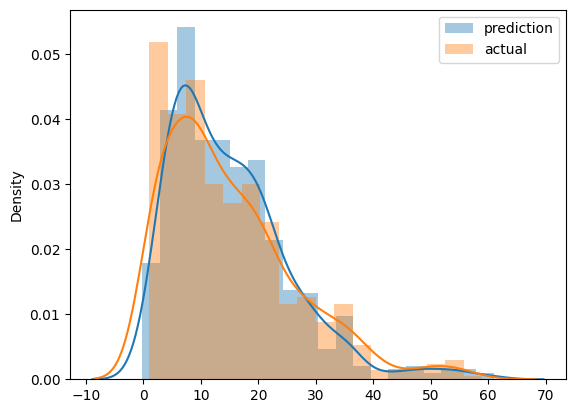

In [24]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()
plt.show()

In [25]:
root_mean_squared_error(y_train, y_pred)

4.803126149499836

In [26]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [28]:
len(df_train), len(df_val)

(73908, 61921)

In [29]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [30]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715208009878

In [33]:
with open('models copy/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [45]:
with mlflow.start_run():
    
    mlflow.set_tag("dev", "Chief Data Scientist, Adebayo")
    mlflow.log_param("train_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)


    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print(rmse)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path = "models copy/lin_reg.bin", artifact_path = "models_pickle")




12.143233939842847


In [50]:
import xgboost as xgb

from hyperopt import fmin, tpe, STATUS_OK, Trials, hp
from hyperopt.pyll import scope
from mlflow.models.signature import infer_signature

In [38]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [39]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',  # use modern version
    'seed': 42,
}


In [40]:
def objective(params):
    # Ensure no active run is open
    if mlflow.active_run():
        mlflow.end_run()

    run = mlflow.start_run()
    try:
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        y_pred = booster.predict(valid)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mlflow.log_metric("rmse", rmse)
        return {'loss': rmse, 'status': STATUS_OK}

    except Exception as e:
        mlflow.log_param("error", str(e))
        raise e

    finally:
        mlflow.end_run()


In [39]:
# trials = Trials()

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=trials
# )

# print("Best hyperparameters found:", best_result)


In [ ]:
params = {
    'learning_rate': 0.20472169880371677,
    'max_depth': 17,
    'min_child_weight': 1.2402611720043835,
    'objective': 'reg:squarederror',  # ✅ Updated (reg:linear is deprecated)
    'reg_alpha': 0.28567896734700793,
    'reg_lambda': 0.004264404814393109,
    'seed': 42
}

# Ensure clean run state
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run():
    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="xgb_model")

    print(f"RMSE: {rmse:.4f}")


2025/07/02 23:20:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/python/3.12.1/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [23:20:49] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/02 23:20:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 6.5054


In [52]:
with mlflow.start_run():
    
    best_params = {
    'learning_rate': 0.0958535536915604,
    'max_depth': 30,
    'min_child_weight': 1.060597050922164,
    'objective': 'reg:squarederror',  # ✅ Updated (reg:linear is deprecated)
    'reg_alpha': 0.01806024404,
    'reg_lambda': 0.01165873137741,
    'seed': 42
    }
    mlflow.log_params(best_params)
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    input_example = X_val[:5]
    signature = infer_signature(X_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)
    # mlflow.xgboost.log_model(booster, name="models_mlflow")
    mlflow.xgboost.log_model(xgb_model=booster, name="models_mlflow", input_example=input_example, signature=signature)


[0]	validation-rmse:10.62105
[1]	validation-rmse:9.45454
[2]	validation-rmse:8.61244
[3]	validation-rmse:8.02161
[4]	validation-rmse:7.60613
[5]	validation-rmse:7.31430
[6]	validation-rmse:7.11506
[7]	validation-rmse:6.97578
[8]	validation-rmse:6.87711
[9]	validation-rmse:6.80659
[10]	validation-rmse:6.75482
[11]	validation-rmse:6.71870
[12]	validation-rmse:6.68975
[13]	validation-rmse:6.67024
[14]	validation-rmse:6.65272
[15]	validation-rmse:6.63910
[16]	validation-rmse:6.62823
[17]	validation-rmse:6.62004
[18]	validation-rmse:6.61336
[19]	validation-rmse:6.60866
[20]	validation-rmse:6.60602
[21]	validation-rmse:6.60323
[22]	validation-rmse:6.60192
[23]	validation-rmse:6.60053
[24]	validation-rmse:6.59835
[25]	validation-rmse:6.59609
[26]	validation-rmse:6.59387
[27]	validation-rmse:6.59214
[28]	validation-rmse:6.59088
[29]	validation-rmse:6.58932
[30]	validation-rmse:6.58731
[31]	validation-rmse:6.58478
[32]	validation-rmse:6.58333
[33]	validation-rmse:6.58150
[34]	validation-rmse:6.

/usr/local/python/3.12.1/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [00:14:53] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)


In [ ]:
rm -rf ./mlruns/555618917946050921
